# Données du projet - *correction*




In [1]:
import pymongo
import pandas
from pprint import pprint
import seaborn
%matplotlib inline

In [2]:
con = pymongo.MongoClient("mongodb://193.51.82.104:2343/")
horo = con.horodateurs

## Mobiliers

### 1. Donner les différents types d'alimentation possible (`alim`) et le nombre d'horodateurs pour chaque. 

In [3]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.alim", "nb" : { "$sum" : 1}}}
]))
pprint(res)

[{'_id': None, 'nb': 8},
 {'_id': 'PILE', 'nb': 2994},
 {'_id': 'SOLAIRE', 'nb': 4808}]


In [4]:
df = pandas.DataFrame(res) 
df.columns = ["Alimentation", "Effectif"]
df

,Alimentation,Effectif
0,None,8
1,PILE,2994
2,SOLAIRE,4808


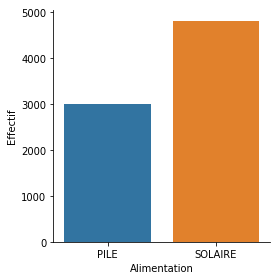

In [5]:
seaborn.factorplot(x = "Alimentation", y = "Effectif", data = df, kind = "bar")

### 2. Donner le nombre de mobiliers pour chaque arrondissement (`arrondt`)

In [6]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1}}},
    { "$sort" : { "_id": 1}}
]))

In [7]:
df = pandas.DataFrame(res) 
df.columns = ["Arrondissement", "Effectif"]

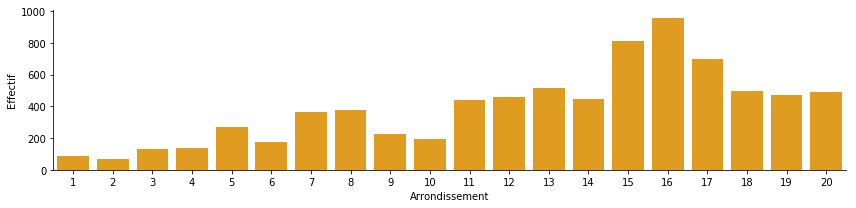

In [8]:
seaborn.factorplot(x = "Arrondissement", y = "Effectif", color = "orange",
                   data = df, kind = "bar", size = 3, aspect = 4)

### 3. Lister l'ensemble des modèles existants (`modele`)

In [9]:
horo.mobiliers.distinct("fields.modele")

['SAB3', 'SMB2', 'MUI']

In [10]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : "$fields.modele", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb": -1}}
]))

In [11]:
df = pandas.DataFrame(res) 
df.columns = ["Modèle", "Effectif"]

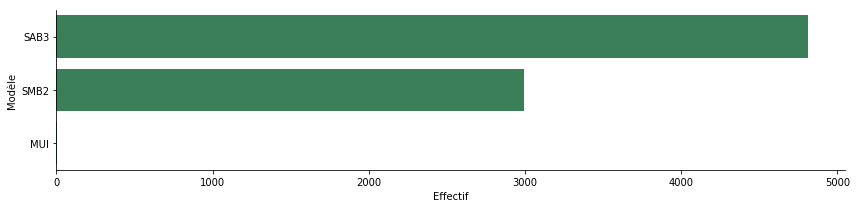

In [12]:
seaborn.factorplot(y = "Modèle", x = "Effectif", color = "seagreen",
                   data = df, kind = "bar", size = 3, aspect = 4)

### 4. Croiser le régime (`regime`) et les arrondissements pour voir s'il y a des différences notables

In [13]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : { "reg" : "$fields.regime", "arr" : "$fields.arrondt"}, "nb" : { "$sum" : 1}}},
    { "$project": { "regime" : "$_id.reg", "arrondissement" : "$_id.arr", "effectif" : "$nb" }},
    { "$sort" : { "arrondissement" : 1}}
]))
df = pandas.DataFrame(res).drop("_id", 1)
df.head()

,arrondissement,effectif,regime
0,1,24,ROT
1,1,63,MIX
2,2,18,ROT
3,2,49,MIX
4,3,82,MIX


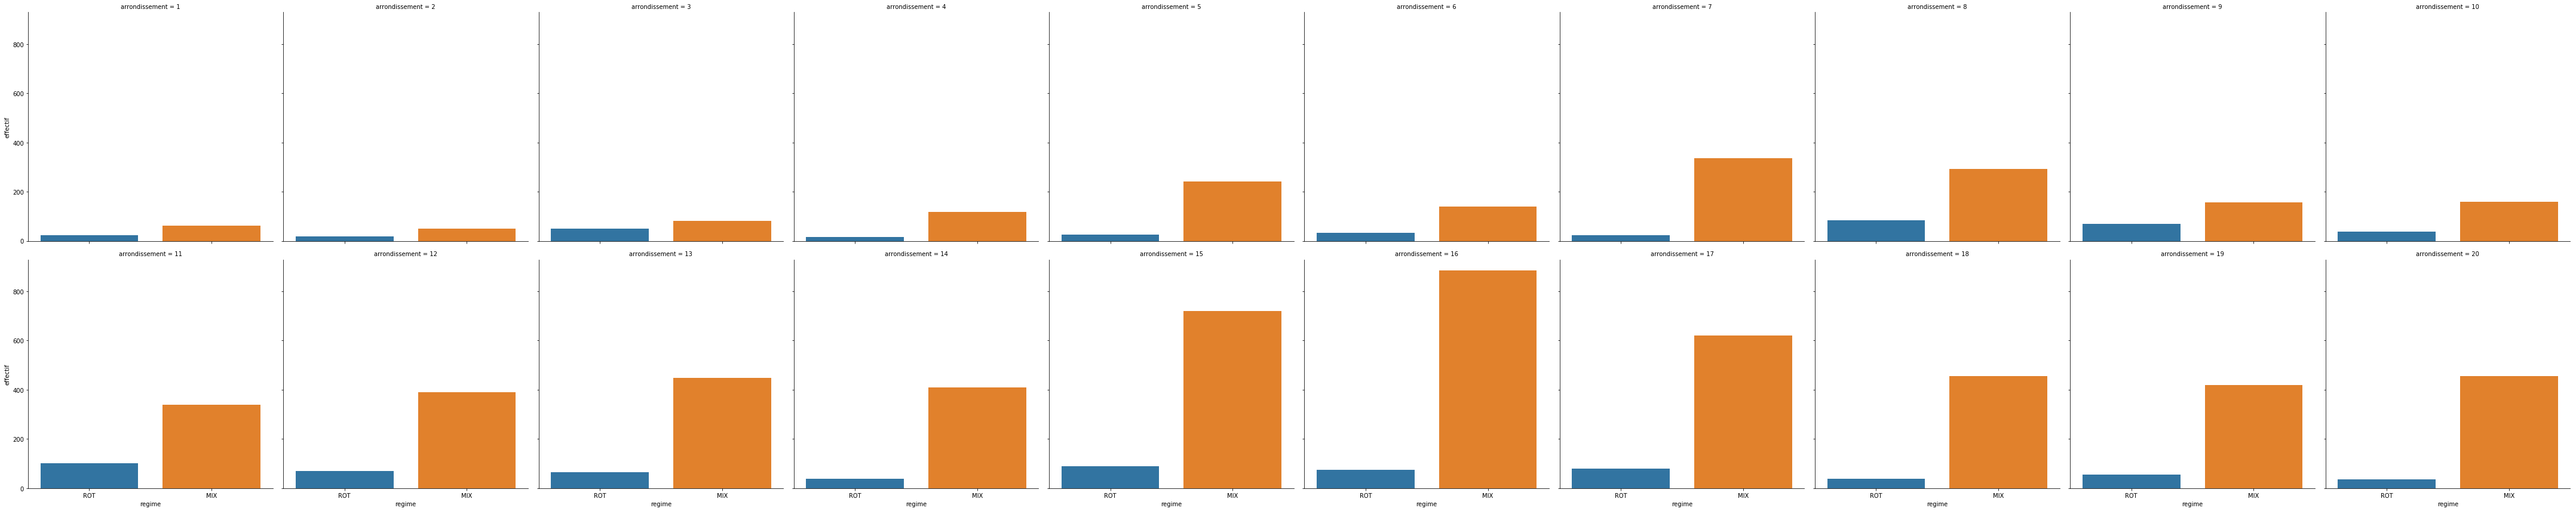

In [14]:
seaborn.factorplot(x = "regime", y = "effectif",
                   col = "arrondissement", col_wrap = 10,
                   data = df, kind = "bar", size = 6)

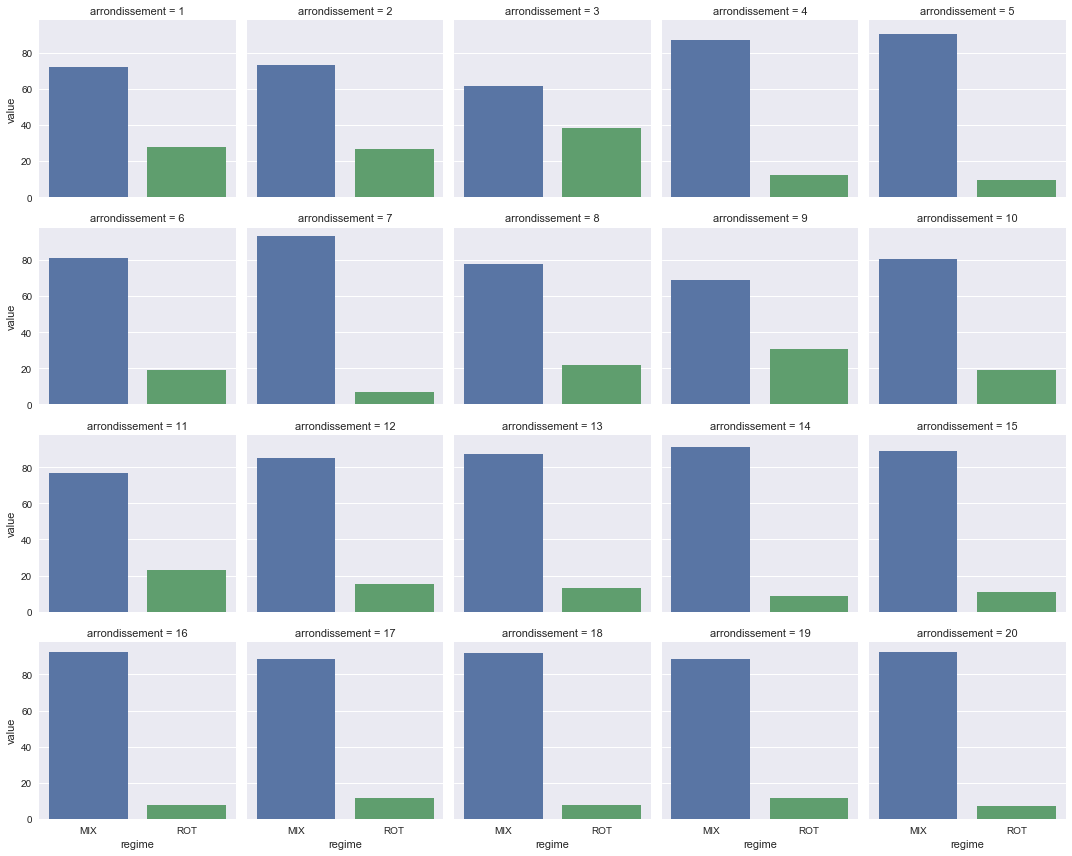

In [15]:
t = pandas.crosstab(df.regime, df.arrondissement, df.effectif, normalize = "columns", aggfunc = sum)
t = t.assign(regime = t.index)
tm = pandas.melt(t, id_vars = "regime")
tm = tm.assign(value = 100 * tm.value)

seaborn.factorplot(x = "regime", y = "value", 
                   col = "arrondissement", col_wrap = 5, 
                   data = tm, kind = "bar", size = 3)

### 5. Idem avec le tarif horaire (`tarifhor`)

In [15]:
res = list(horo.mobiliers.aggregate([
    { "$group" : { "_id" : { "tar" : "$fields.tarifhor", "arr" : "$fields.arrondt"}, "nb" : { "$sum" : 1}}},
    { "$project": { "tarif" : "$_id.tar", "arrondissement" : "$_id.arr", "effectif" : "$nb" }},
    { "$sort" : { "arrondissement" : 1}}
]))
df = pandas.DataFrame(res).drop("_id", 1)
df.head()

,arrondissement,effectif,tarif
0,1,87,4.0
1,2,67,4.0
2,3,133,4.0
3,4,135,4.0
4,5,267,4.0


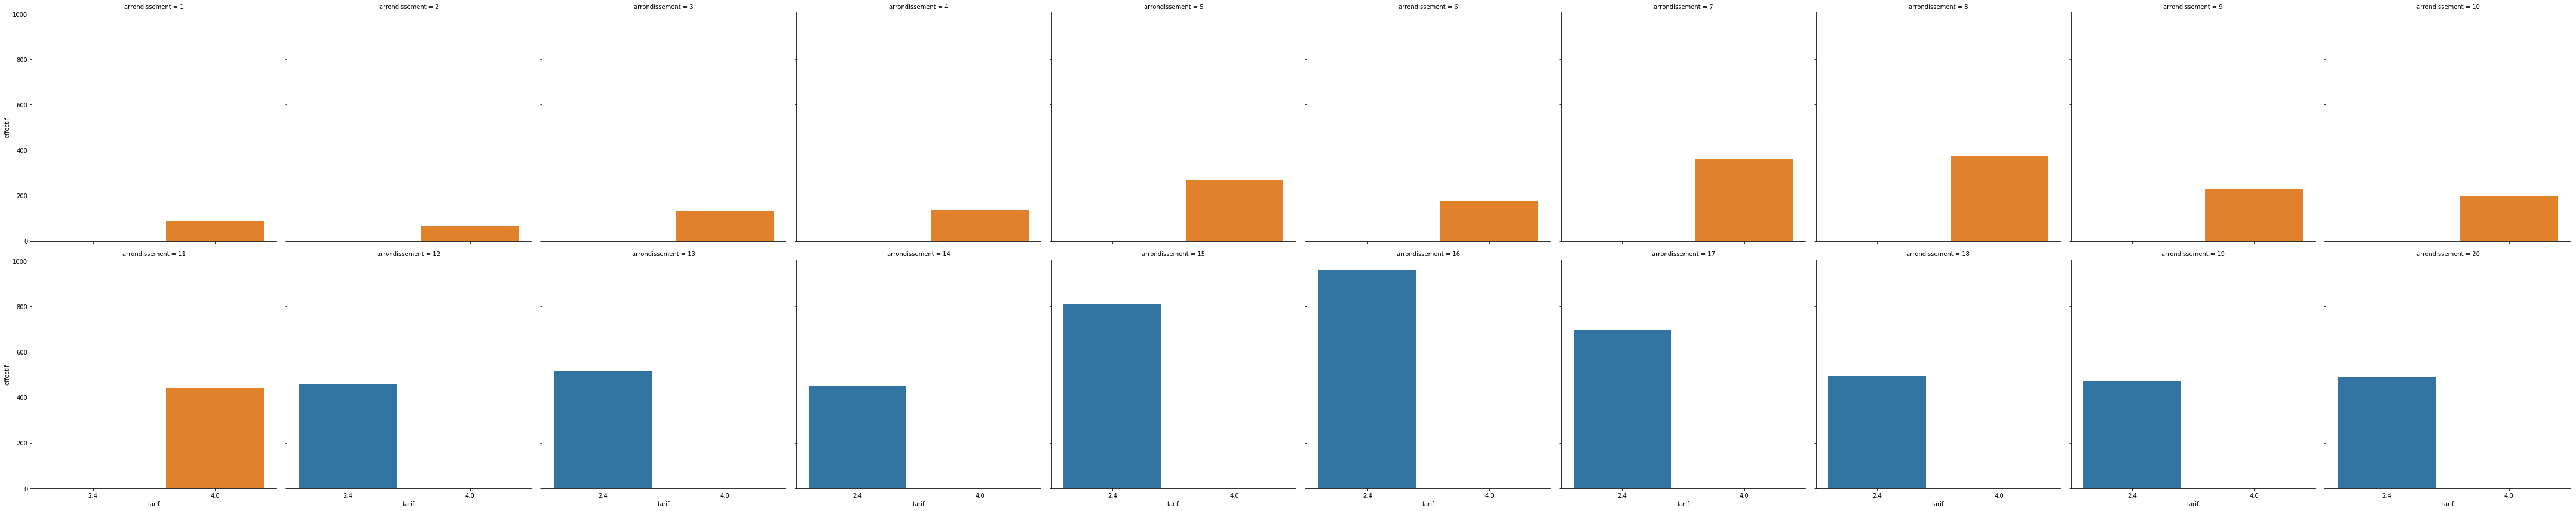

In [16]:
seaborn.factorplot(x = "tarif", y = "effectif",
                   col = "arrondissement", col_wrap = 10,
                   data = df, kind = "bar", size = 6)

## Transactions

### 1. Donner la distribution des montants payés (`montant carte`) et des durées payées (`durée payée (h)`)

In [17]:
res = list(horo.transactions_small.find({}, {"_id": 0, "montant carte" : 1}))

In [18]:
df = pandas.DataFrame(res)

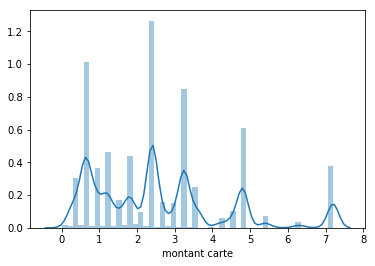

In [19]:
seaborn.distplot(df["montant carte"])

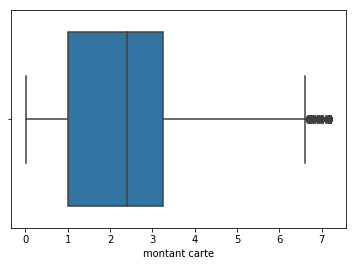

In [20]:
seaborn.boxplot(x = "montant carte", data = df)

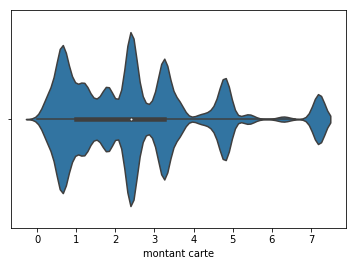

In [21]:
seaborn.violinplot(x = "montant carte", data = df)

### 2. Lister les différents moyens de paiements utilisés (`moyen de paiement`) et le type d'usager (`usager`), en ordonnant chaque table résultat par ordre décroissant du nombre de paiements

In [22]:
res = list(horo.transactions.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb" : -1 }}
]))
pprint(pandas.DataFrame(res))

           _id        nb
0  Paris Carte  13181015
1           CB  11267015


In [23]:
res = list(horo.transactions.aggregate([
    { "$group" : { "_id" : "$usager", "nb" : { "$sum" : 1}}},
    { "$sort" : { "nb" : -1 }}
]))
pprint(pandas.DataFrame(res))

        _id        nb
0   Rotatif  19033897
1  Résident   5414133


### 3. Déterminer s'il existe un lien entre le moyen de paiement, et le montant d'une part et la durée d'autre part

In [24]:
res = list(horo.transactions_small.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "montant" : { "$avg" : "$montant carte"}}},
    { "$sort" : { "nb" : -1 }}
]))
pprint(pandas.DataFrame(res))

           _id   montant
0           CB  3.007229
1  Paris Carte  2.161537


In [25]:
res = list(horo.transactions_small.aggregate([
    { "$group" : { "_id" : "$moyen de paiement", "durée" : { "$avg" : "$durée payée (h)"}}},
    { "$sort" : { "nb" : -1 }}
]))
pprint(pandas.DataFrame(res))

           _id     durée
0           CB  8.254365
1  Paris Carte  8.261151


## Jointures

### 1. Calculer le nombre de transactions par arrondissement

In [26]:
res = list(horo.mobiliers.aggregate([
#    { "$limit" : 100 },
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transactions"
    }},
    { "$project" : { "Arrondissement" : "$fields.arrondt", "Nb" : { "$size" : "$transactions" }, "_id" : 0}},
    { "$group" : { "_id" : "$Arrondissement", "nb" : { "$sum" : "$Nb" }}}
]))
pprint(res)

[{'_id': 1, 'nb': 2539},
 {'_id': 6, 'nb': 6784},
 {'_id': 3, 'nb': 4250},
 {'_id': 11, 'nb': 12309},
 {'_id': 12, 'nb': 15746},
 {'_id': 10, 'nb': 5487},
 {'_id': 14, 'nb': 16671},
 {'_id': 2, 'nb': 1787},
 {'_id': 15, 'nb': 24863},
 {'_id': 17, 'nb': 20413},
 {'_id': 4, 'nb': 3884},
 {'_id': 7, 'nb': 12024},
 {'_id': 19, 'nb': 11146},
 {'_id': 13, 'nb': 20889},
 {'_id': 5, 'nb': 9005},
 {'_id': 8, 'nb': 15113},
 {'_id': 18, 'nb': 11235},
 {'_id': 20, 'nb': 12647},
 {'_id': 9, 'nb': 8021},
 {'_id': 16, 'nb': 27718}]


In [27]:
res = list(horo.mobiliers.aggregate([
#    { "$limit" : 100 },
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transactions"
    }},
    { "$unwind" : "$transactions" },
    { "$group" : { "_id" : "$fields.arrondt", "nb" : { "$sum" : 1 }}}
]))
pprint(res)

[{'_id': 1, 'nb': 2539},
 {'_id': 6, 'nb': 6784},
 {'_id': 3, 'nb': 4250},
 {'_id': 11, 'nb': 12309},
 {'_id': 12, 'nb': 15746},
 {'_id': 10, 'nb': 5487},
 {'_id': 14, 'nb': 16671},
 {'_id': 2, 'nb': 1787},
 {'_id': 15, 'nb': 24863},
 {'_id': 17, 'nb': 20413},
 {'_id': 4, 'nb': 3884},
 {'_id': 7, 'nb': 12024},
 {'_id': 19, 'nb': 11146},
 {'_id': 13, 'nb': 20889},
 {'_id': 5, 'nb': 9005},
 {'_id': 8, 'nb': 15113},
 {'_id': 18, 'nb': 11235},
 {'_id': 20, 'nb': 12647},
 {'_id': 9, 'nb': 8021},
 {'_id': 16, 'nb': 27718}]


In [28]:
df = pandas.DataFrame(res)
df.columns = [ "Arrondissement", "NbTransactions"]
df = df.sort_values(by = "Arrondissement").reset_index()
df

,index,Arrondissement,NbTransactions
0,0,1,2539
1,7,2,1787
2,2,3,4250
3,10,4,3884
4,14,5,9005
5,1,6,6784
6,11,7,12024
7,15,8,15113
8,18,9,8021
9,5,10,5487


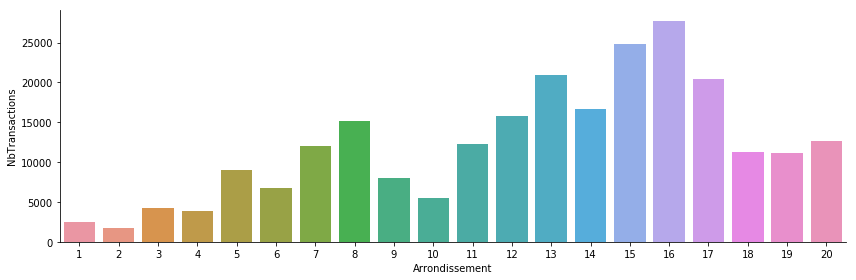

In [29]:
seaborn.factorplot(x = "Arrondissement", y = "NbTransactions",
                   data = df, kind = "bar", size = 4, aspect = 3)

### 2. Calculer la répartition du type d'alimentation par arrondissement

In [30]:
res = list(horo.mobiliers.aggregate([
    { "$lookup": {
        "from": "transactions_small",
        "localField": "fields.numhoro",
        "foreignField": "horodateur",
        "as": "transactions"
    }},
    { "$unwind" : "$transactions" },
#    { "$limit" : 10000},
    { "$group" : { "_id" : { "arrondissement" : "$fields.arrondt", "type" : "$fields.alim" }, "nb" : { "$sum" : 1 }}},
    { "$match" : { "_id.type" : {"$exists" : True }}}
]))
pprint(res)

[{'_id': {'arrondissement': 7, 'type': 'SOLAIRE'}, 'nb': 1340},
 {'_id': {'arrondissement': 6, 'type': 'PILE'}, 'nb': 2414},
 {'_id': {'arrondissement': 5, 'type': 'SOLAIRE'}, 'nb': 1158},
 {'_id': {'arrondissement': 9, 'type': 'PILE'}, 'nb': 6},
 {'_id': {'arrondissement': 18, 'type': 'SOLAIRE'}, 'nb': 4504},
 {'_id': {'arrondissement': 7, 'type': 'PILE'}, 'nb': 10684},
 {'_id': {'arrondissement': 6, 'type': 'SOLAIRE'}, 'nb': 4370},
 {'_id': {'arrondissement': 9, 'type': 'SOLAIRE'}, 'nb': 8015},
 {'_id': {'arrondissement': 19, 'type': 'SOLAIRE'}, 'nb': 5184},
 {'_id': {'arrondissement': 20, 'type': 'SOLAIRE'}, 'nb': 12640},
 {'_id': {'arrondissement': 5, 'type': 'PILE'}, 'nb': 7847},
 {'_id': {'arrondissement': 13, 'type': 'SOLAIRE'}, 'nb': 20865},
 {'_id': {'arrondissement': 8, 'type': 'SOLAIRE'}, 'nb': 15074},
 {'_id': {'arrondissement': 18, 'type': 'PILE'}, 'nb': 6731},
 {'_id': {'arrondissement': 20, 'type': 'PILE'}, 'nb': 7},
 {'_id': {'arrondissement': 2, 'type': 'SOLAIRE'}, 'nb

In [31]:
df = pandas.DataFrame(res)
df = df.assign(
    Arrondissement = [a['arrondissement'] for a in df._id],
    Alimentation = [a['type'] for a in df._id]
).drop("_id", 1)
df

,nb,Alimentation,Arrondissement
0,1340,SOLAIRE,7
1,2414,PILE,6
2,1158,SOLAIRE,5
3,6,PILE,9
4,4504,SOLAIRE,18
5,10684,PILE,7
6,4370,SOLAIRE,6
7,8015,SOLAIRE,9
8,5184,SOLAIRE,19
9,12640,SOLAIRE,20


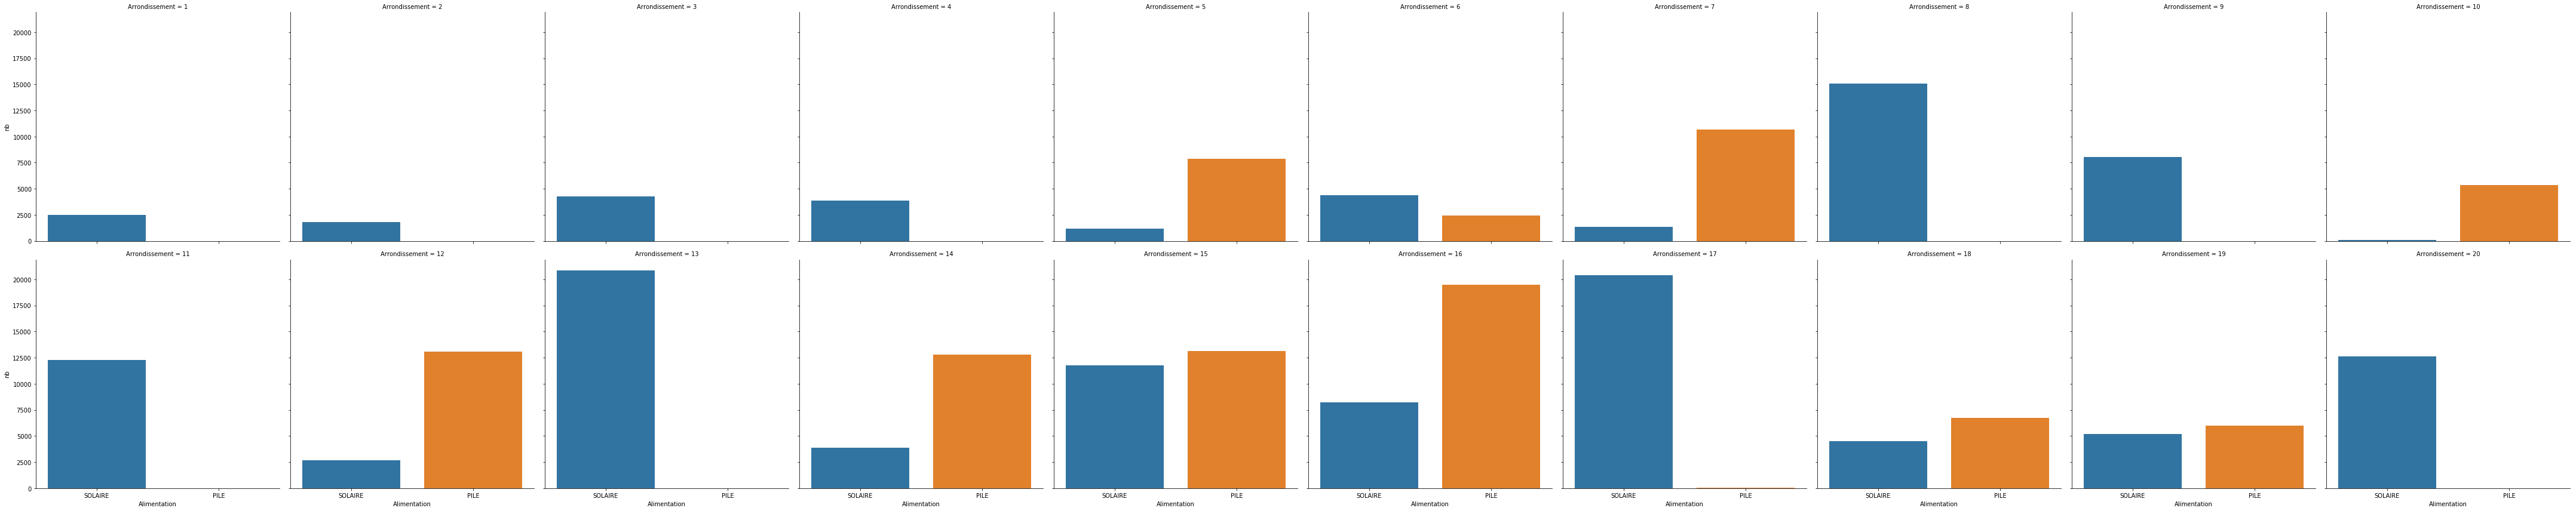

In [32]:
seaborn.factorplot(x = "Alimentation", y = "nb",
                   col = "Arrondissement", col_wrap = 10,
                   data = df, kind = "bar", size = 6)

In [33]:
cross = pandas.crosstab(df.Arrondissement, df.Alimentation, values = df.nb, aggfunc = sum, normalize = "index")
cross = cross.assign(Arrondissement = cross.index)
cross

Alimentation,PILE,SOLAIRE,Arrondissement
Arrondissement,,,
1,0.000000,1.000000,1
2,0.000000,1.000000,2
3,0.000000,1.000000,3
4,0.000000,1.000000,4
5,0.871405,0.128595,5
6,0.355837,0.644163,6
7,0.888556,0.111444,7
8,0.000000,1.000000,8
9,0.000748,0.999252,9


In [34]:
crossm = pandas.melt(cross, id_vars = "Arrondissement")
crossm = crossm.assign(value = 100 * crossm.value)
crossm

,Arrondissement,Alimentation,value
0,1,PILE,0.000000
1,2,PILE,0.000000
2,3,PILE,0.000000
3,4,PILE,0.000000
4,5,PILE,87.140478
5,6,PILE,35.583726
6,7,PILE,88.855622
7,8,PILE,0.000000
8,9,PILE,0.074804
9,10,PILE,97.940587


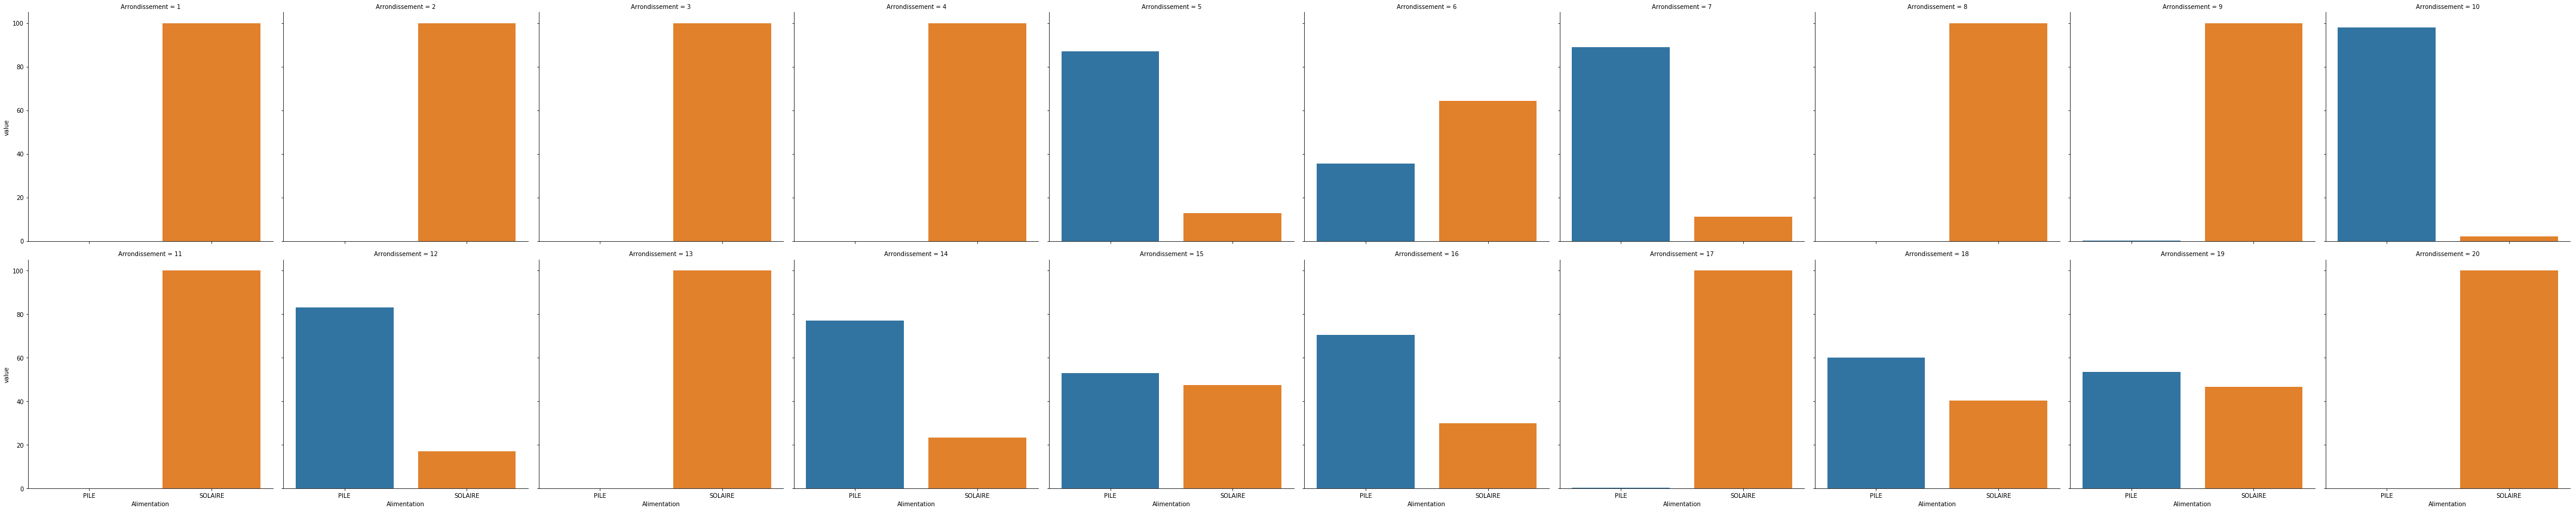

In [35]:
seaborn.factorplot(x = "Alimentation", y = "value", 
                   col = "Arrondissement", col_wrap = 10,
                   data = crossm, kind = "bar", size = 6)